In [1]:
%cd /Users/gwg/dmcm
%matplotlib inline

/Users/gwg/dmcm


In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from   PIL import Image

from   data import GTExV8Config, GTExV8Dataset, loader
from   models import DPCCA, DCGANAE128

In [3]:
cfg = GTExV8Config()
directory = '/Users/gwg/dmcm/experiments/20190131_big_sweep/'\
            'gtexv8_mode-dpcca_batch_size-128_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.5_em_iters-1_clip-1'

train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    directory=directory)
dataset = GTExV8Dataset(cfg)

In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
all_tissues = dataset.tissues_df.values.squeeze()
le.fit(all_tissues)
tissue_nums = le.transform(all_tissues)

inds = test_loader.sampler.indices
n    = len(inds)

X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
X2 = torch.Tensor(n, cfg.N_GENES)
labels = torch.Tensor(n)
tissues = []

for j, i in enumerate(inds):
    x1, x2 = dataset[i]
    X1[j] = x1
    X2[j] = x2
    labels[j] = float(tissue_nums[i])
    tissues.append(all_tissues[i])

tissues = np.array(tissues)

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [6]:
def get_image_net():
    return DCGANAE128(cfg)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

cfg.get_image_net = get_image_net
state = torch.load(directory + '/model.pt', map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=10)
model.load_state_dict(state)

In [9]:
ne1 = model.image_net.encode(X1).detach().numpy()
ne1 = pca.fit_transform(ne1)
ne2 = model.genes_net.encode(X2).detach().numpy()
ne2 = pca.fit_transform(ne2)

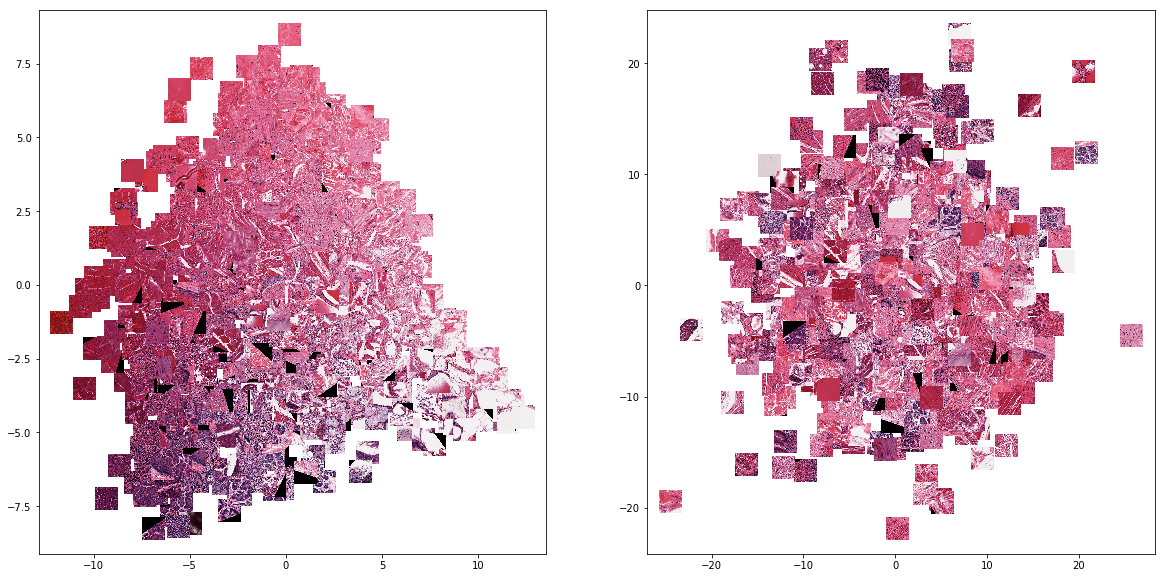

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for X, ne, ax in zip([X1, X1], [ne1, ne2], axes.flat):
    for x, emb in zip(X, ne):
        if len(x.shape) == 3:
            x = x.transpose(0, 2)
        imscatter(emb[0], emb[1], x, ax, zoom=0.1)